**Neccesary** **Libraries**


In [ ]:
#libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout, Multi
from tensorflow.data import Dataset
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import random
import time
import re
plt.style.use('ggplot')
import seaborn as sns


# Preprocessing and Getting Data

- import Tokenizer for tokenizing words

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

- initialize chinese and english tokenizers

In [ ]:
en_tokenizer = Tokenizer(num_words = 25000, oov_token='<OOV>', filters='')

ch_tokenizer = Tokenizer(oov_token='<OOV>', filters='')

- alphabet and numbers for Chinese preprocessing

In [ ]:
 alpha = 'abcdefghijklmnopqrtstuvwxyz1234567890-/'

- preproccessing for sentences

In [ ]:
def en_preprocess_sentence(x):
    x = x.lower().strip()

    lst = []
    for i in x.split():
      try:
        y = num2words(i)
        lst.append(y)
      except:
        lst.append(i)
    
    x = ' '.join(lst)

    x = re.sub(r"([?.!,¿])", r" \1 ", x)
    x = re.sub(r'[" "]+', " ", x)
    x = x.replace('-',' ')
    x = x.strip()
    
    x = '<start> ' + x + ' <end>'
    
    return x

In [ ]:
def ch_preprocess_sentence(x):
  x = x.split()
  lst = []
  for i in x:
    try:
      y = num2words(i)
      lst.append(y)
    except:
      for j in i:
        if j.lower() not in alpha:
          lst.append(j)
            
  x = ' '.join(lst)
  x = re.sub(r"([?.!,¿])", r" \1 ", x)
  x = re.sub(r'[" "]+', " ", x)
  x = x.replace('-',' ')
  x = x.strip()
  
  x = '<start> ' + x + ' <end>'

  return x

- arrays to store all data for English and Chinese



*   **Data from [UM Corpus](http://nlp2ct.cis.umac.mo/um-corpus/)**
*   Download data from this link and import it into Google Drive



In [ ]:
import os
en_data_total = []
ch_data_total = []

- load data into each array from all text files

In [ ]:
data_categories = ["Spoken","Microblog"]

en_data_test = []
ch_data_test = []

for category in data_categories:
  with open(f'/content/drive/MyDrive/Bilingual/{category}/Bi-{category}.txt') as f:
    data = f.readlines()
    data_en = [en_preprocess_sentence(i) for i in data[::2]]
    data_ch = [ch_preprocess_sentence(i) for i in data[1::2]]
    print(len(data_en))
    del data

    if category == "Subtitles":
      total = list(zip(data_en, data_ch))

      random.shuffle(total)
      data_en, data_ch = zip(*total)

      data_en = list(data_en)
      data_ch = list(data_ch)

      data_en = data_en[:100000]
      data_ch = data_ch[:100000]


      en_data_total.extend(data_en)
      ch_data_total.extend(data_ch)

    elif category == "Microblog":
      en_data_test.extend(data_en)
      ch_data_test.extend(data_ch)

    elif category == "Spoken":
      en_data_total.extend(data_en)
      ch_data_total.extend(data_ch)


220000
5000


In [ ]:
en_data_total_new = []
ch_data_total_new = []

for i in range(len(en_data_total)):
  if len(en_data_total[i].split()) <= 50:
    en_data_total_new.append(en_data_total[i])
    ch_data_total_new.append(ch_data_total[i])

en_data_test_new = []
ch_data_test_new = []

for i in range(len(en_data_test)):
  if len(en_data_test[i].split()) <= 50:
    en_data_test_new.append(en_data_test[i])
    ch_data_test_new.append(ch_data_test[i])

en_data_test = en_data_test_new
ch_data_test = ch_data_test_new

del en_data_test_new
del ch_data_test_new



en_data_total = en_data_total_new
ch_data_total = ch_data_total_new

In [ ]:
for i in range(10):
  rand = random.randint(0,len(en_data_total))
  print(f'Chinese sentence {i}: {ch_data_total[rand]}')
  print(f'English translation {i}: {en_data_total[rand]}')

Chinese sentence 0: <start> 那 幅 不 大 的 画 原 来 是 柯 勒 乔 的 一 幅 未 被 发 现 的 杰 作 ， 价 值 几 十 万 英 镑 。 <end>
English translation 0: <start> the tiny painting proved to be an unknown masterpiece by correggio and was worth hundreds of thousands of pounds . <end>
Chinese sentence 1: <start> 他 说 ： “ 我 不 干 了 ， 我 受 够 了 <end>
English translation 1: <start> he just said , that's it . i'm done . that's enough . <end>
Chinese sentence 2: <start> 读 完 一 本 书 ， 有 不 完 全 理 解 的 地 方 是 很 自 然 的 。 没 关 系 。 把 它 搁 在 一 边 ， 再 读 另 一 本 。 <end>
English translation 2: <start> after reading a book , it is only natural that you don't understand it all . never mind . put it aside and start another one . <end>
Chinese sentence 3: <start> 我 们 已 安 排 用 火 车 运 输 你 们 所 需 的 大 米 。 <end>
English translation 3: <start> we have arranged to transport the rice you purchased by rail . <end>
Chinese sentence 4: <start> ： 我 们 下 一 项 技 术 实 际 上 是 一 个 英 尺 的 棍 子 ， <end>
English translation 4: <start> zk: now , our next technology is actually a 10 foot 

- fit tokenizer

In [ ]:
en_tokenizer.fit_on_texts(en_data_total) 
ch_tokenizer.fit_on_texts(ch_data_total)



*   Save both tokenizers to a pickle file so they can easily be loaded later



In [ ]:
import pickle

with open("/content/drive/MyDrive/en_tokenizer.pickle", "wb") as handle:
  pickle.dump(en_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("/content/drive/MyDrive/ch_tokenizer.pickle", "wb") as handle:
  pickle.dump(ch_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

- tokenize data

In [ ]:
tensor_en_data_total = en_tokenizer.texts_to_sequences(en_data_total)

tensor_ch_data_total = ch_tokenizer.texts_to_sequences(ch_data_total)

tensor_en_data_test = en_tokenizer.texts_to_sequences(en_data_test)

tensor_ch_data_test = ch_tokenizer.texts_to_sequences(ch_data_test)

- pad tokenized tensors

In [ ]:
tensor_en_data_total= tf.keras.preprocessing.sequence.pad_sequences(tensor_en_data_total, padding='post')
tensor_en_data_total = tf.cast(tensor_en_data_total, tf.int64)

np.save("/content/drive/MyDrive/tensor_en_data.npy", tensor_en_data_total.numpy())

tensor_ch_data_total = tf.keras.preprocessing.sequence.pad_sequences(tensor_ch_data_total, padding='post')
tensor_ch_data_total = tf.cast(tensor_ch_data_total, tf.int64)

np.save("/content/drive/MyDrive/tensor_ch_data.npy", tensor_ch_data_total.numpy())

In [ ]:
len_enc = tensor_ch_data_total.shape[1]
len_dec = tensor_en_data_total.shape[1]

In [ ]:
tensor_en_data_test = tf.keras.preprocessing.sequence.pad_sequences(tensor_en_data_test, maxlen=len_dec, padding='post')
tensor_en_data_test = tf.cast(tensor_en_data_test, tf.int64)

np.save("/content/drive/MyDrive/test_en_data.npy", tensor_en_data_test.numpy())

tensor_ch_data_test = tf.keras.preprocessing.sequence.pad_sequences(tensor_ch_data_test, maxlen=len_enc, padding='post')
tensor_ch_data_test = tf.cast(tensor_ch_data_test, tf.int64)

np.save("/content/drive/MyDrive/test_ch_data.npy", tensor_ch_data_test.numpy())

**Start from here if Data processing was already finished**

In [ ]:
tensor_en_data_total = tf.convert_to_tensor(np.load("/content/drive/MyDrive/tensor_en_data.npy"))
tensor_ch_data_total = tf.convert_to_tensor(np.load("/content/drive/MyDrive/tensor_ch_data.npy"))

tensor_en_data_test = tf.convert_to_tensor(np.load("/content/drive/MyDrive/test_en_data.npy"))
tensor_ch_data_test = tf.convert_to_tensor(np.load("/content/drive/MyDrive/test_ch_data.npy"))

In [ ]:
import pickle
with open("/content/drive/MyDrive/en_tokenizer.pickle", "rb") as handle:
  en_tokenizer = pickle.load(handle)
with open("/content/drive/MyDrive/ch_tokenizer.pickle", "rb") as handle:
  ch_tokenizer = pickle.load(handle)

In [ ]:
def iterate_through_training_sentences():
  for x,y in zip(tensor_ch_data_total[:200000,],tensor_en_data_total[:200000,]):
    yield x,y

def iterate_through_val_sentences():
  for x,y in zip(tensor_ch_data_total[200000:,],tensor_en_data_total[200000:,]):
    yield x,y

def iterate_through_test_sentences():
  for x,y in zip(tensor_ch_data_test,tensor_en_data_test):
    yield x,y

- all hyperparameters
- **Play around with these hyperparameters to improve the model's performance!**

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EPOCHS = 50
num_layers = 4
d_model = 256
dff = 1024
dropout_rate = 0.3
num_heads = 8
enc_vocab_size = len(ch_tokenizer.word_index) + 1
dec_vocab_size = en_tokenizer.num_words + 1
max_pos_enc = tensor_ch_data_total.shape[1]
max_pos_dec = tensor_en_data_total.shape[1]

- turn data into tf dataset and batch

In [ ]:
training_dataset = Dataset.from_generator(iterate_through_training_sentences, output_signature = (tf.TensorSpec(shape=(max_pos_enc,), dtype=tf.int64),
                                                                               tf.TensorSpec(shape=(max_pos_dec,), dtype=tf.int64))).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


val_dataset = Dataset.from_generator(iterate_through_val_sentences, output_signature = (tf.TensorSpec(shape=(max_pos_enc,), dtype=tf.int64),
                                                                               tf.TensorSpec(shape=(max_pos_dec,), dtype=tf.int64))).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = Dataset.from_generator(iterate_through_test_sentences, output_signature = (tf.TensorSpec(shape=(max_pos_enc,), dtype=tf.int64),
                                                                               tf.TensorSpec(shape=(max_pos_dec,), dtype=tf.int64))).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Transformer

Positional encoding

- gives the Transformer a way to know position it is currently on
- easy for the Transformer to learn this sinusoidal function

In [ ]:
#positional encoding function

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def pos_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


Plot of the Positional Encoding Function



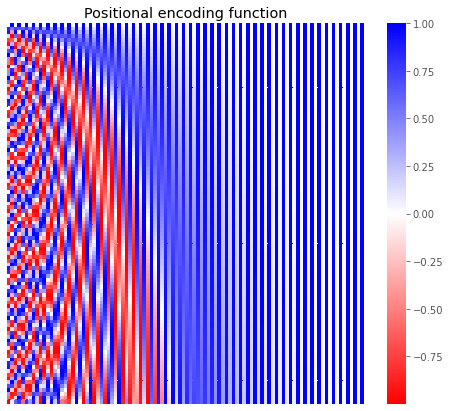

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(pos_encoding(100, 100)[0], ax=ax, cmap='bwr_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Positional encoding function')
fig.show()

**Look** **Ahead** **Mask**
- makes the Transformer unable to use future words when predicting the next translation for the current word
- neccesary since the Transformer is fully-connected and needs a way for future words to be hidden

In [ ]:
def create_look_ahead_mask(shape):
  mask = 1 - tf.linalg.band_part(tf.ones((shape,shape)), -1, 0)
  return mask

**Padding Mask**
- makes the Transformer pay very little attention to zero padding in the input
- necessary since Transformers have to be padded

In [ ]:
def create_padding_mask(mat):
  mat = tf.cast(tf.math.equal(mat, 0), tf.float32)
  return mat[:, tf.newaxis, tf.newaxis, :]

**Self** **Attention** **Class**

- class that defines one self-attention block
- parameters are d_model (embedding size) and d_k (output size)
- uses Query, Key, and Value weights to create query, key, and value vectors which are passed through a softmax layer to specify the **Attention** given to each word

In [ ]:
def SelfAttention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True) 

  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 

  output = tf.matmul(attention_weights, v) 

  return output, attention_weights


***Multi-Head Attention Class*** 

- multi-head attention is used to benefit from different self-attention blocks from different spaces
- parameters are d_model , d_k, and num_heads (number of self-attention heads)
- does normal self-attention computation then concatenates the results of the different heads and passes them though a Dense layer to get the final outputs

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % num_heads == 0

    self.depth = d_model // num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q) 
    k = self.wk(k) 
    v = self.wv(v)  

    q = self.split_heads(q, batch_size) 
    k = self.split_heads(k, batch_size)  
    v = self.split_heads(v, batch_size)  

    scaled_attention, attention_weights = SelfAttention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) 

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model)) 

    output = self.dense(concat_attention)

    return output, attention_weights

  
  def get_context(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q) 
    k = self.wk(k) 
    v = self.wv(v)  

    q = self.split_heads(q, batch_size) 
    k = self.split_heads(k, batch_size)  
    v = self.split_heads(v, batch_size)  

    scaled_attention, attention_weights = SelfAttention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) 

    return scaled_attention, attention_weights

***Point-Wise Feed Forward network Class***
- parameters are d_model and d_ff(number of perceptrons in middle layer)
- the point wise feed forward network is used in between the multi-head attention layers to point wise transform the output

In [ ]:
class PointWiseFeedForward(tf.keras.layers.Layer):

  def __init__(self, d_model, dff):
    super(PointWiseFeedForward, self).__init__()
    self.network = tf.keras.Sequential([Dense(dff, activation='relu'),
                                        Dense(d_model)])
  def call(self, x):
    z = self.network(x)
    return z


**Branched Multi Head Attention**


*   From the paper *Weighted Transformer Network for Machine Translation*



In [ ]:
class BranchedMultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, d_ff, n_branches, rate):
    super(BranchedMultiHeadAttention, self).__init__()
    self.d_k = d_model//n_branches
    self.d_v = d_model//n_branches
    self.d_model = d_model
    self.n_branches = n_branches

    self.attention = MultiHeadAttention(d_model, n_branches)

    self.w_o = [Dense(d_model, kernel_initializer='glorot_normal') for i in range(n_branches)]

    self.w_k = tf.random.uniform(shape=[self.n_branches])
    self.w_k = tf.Variable(self.w_k/tf.reduce_sum(self.w_k), trainable=True)

    self.w_a = tf.random.uniform(shape=[self.n_branches])
    self.w_a = tf.Variable(self.w_a/tf.reduce_sum(self.w_a), trainable=True)
    self.d_ff = d_ff

    self.ffn = [PointWiseFeedForward(d_model, d_ff//n_branches) for i in range(n_branches)]

    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)

    self.layer_norm = LayerNormalization()


  def call(self, v, k, q, mask, training):
    batch_size = tf.shape(q)[0]
    len_q = tf.shape(q)[1]
    residual = q
    
    context, attention_weights = self.attention.get_context(v, k, q, mask)
    context = tf.reshape(context, shape=(batch_size, len_q, self.n_branches*self.d_v))

    context = self.dropout1(context, training=training)

    context = tf.split(context, self.n_branches, axis=-1)
    

    outputs = [self.w_o[i](context[i]) for i in range(self.n_branches)]
    outputs = [self.w_k[i] * outputs[i] for i in range(self.n_branches)]
    outputs = [self.ffn[i](outputs[i]) for i in range(self.n_branches)]
    outputs = [self.w_a[i] * outputs[i] for i in range(self.n_branches)]

    outputs = tf.stack(outputs)
    outputs = tf.reduce_sum(outputs, axis=0)

    outputs = tf.convert_to_tensor(outputs)

    outputs = self.dropout2(outputs, training=training)
    
    outputs = self.layer_norm(residual + outputs)

    return outputs, attention_weights



***Encoder Layer Class***

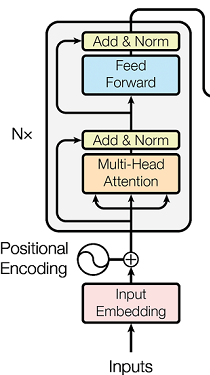

- full encoder layer of the Transformer
- contains 1 Multi-Head Self Attention layer followed by a residual connection from the input embedding and layer normalization, then the output of layer norm goes to the Point Wise Feed Forward and then that output is followed by another residual connection from the output of the Multi-Head attention layer and layer normalized and then passed as the Key and Value vector to each Decoder layer in the decoder


In [ ]:
class EncoderLayer(tf.keras.layers.Layer):

  def __init__(self, d_model, d_ff, num_heads, rate=0.1):

    super(EncoderLayer, self).__init__()
    self.attn = MultiHeadAttention(d_model, num_heads)
    self.ff = PointWiseFeedForward(d_model,d_ff)
    self.layernorm1 = LayerNormalization()
    self.layernorm2 = LayerNormalization()
    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)

  def call(self, x, training, mask):
    attn_output, _ = self.attn(x, x, x, mask) 
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output) 

    ffn_output = self.ff(out1) 
    ffn_output = self.dropout2(ffn_output,training=training)
    out2 = self.layernorm2(out1 + ffn_output)

    return out2

In [ ]:
class WeightedEncoderLayer(tf.keras.layers.Layer):

  def __init__(self, d_model, d_ff, num_heads, rate=0.1):

    super(WeightedEncoderLayer, self).__init__()
    self.attn = BranchedMultiHeadAttention(d_model, d_ff, num_heads, rate)

  def call(self, x, training, mask):
    attn_output, _ = self.attn(x, x, x, mask, training) 

    return attn_output

**Encoder Class**
- comprised of stacked Encoder Layers and an embedding layer with a positional encoding added
- hyperparameters are d_model(embedding size), d_k(output k, q, and v vector size), num_heads, num_layers(number of stacked Encoder Layers)

In [ ]:
class Encoder(tf.keras.layers.Layer):

  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = pos_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model=d_model, d_ff=dff,num_heads=num_heads, rate=rate)
                       for _ in range(num_layers)]

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    x = self.embedding(x) 
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x 





In [ ]:
class WeightedEncoder(tf.keras.layers.Layer):

  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(WeightedEncoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = pos_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [WeightedEncoderLayer(d_model=d_model, d_ff=dff, num_heads=num_heads, rate=rate)
                       for _ in range(num_layers)]

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    x = self.embedding(x) 
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x 

**Decoder Layer Class**

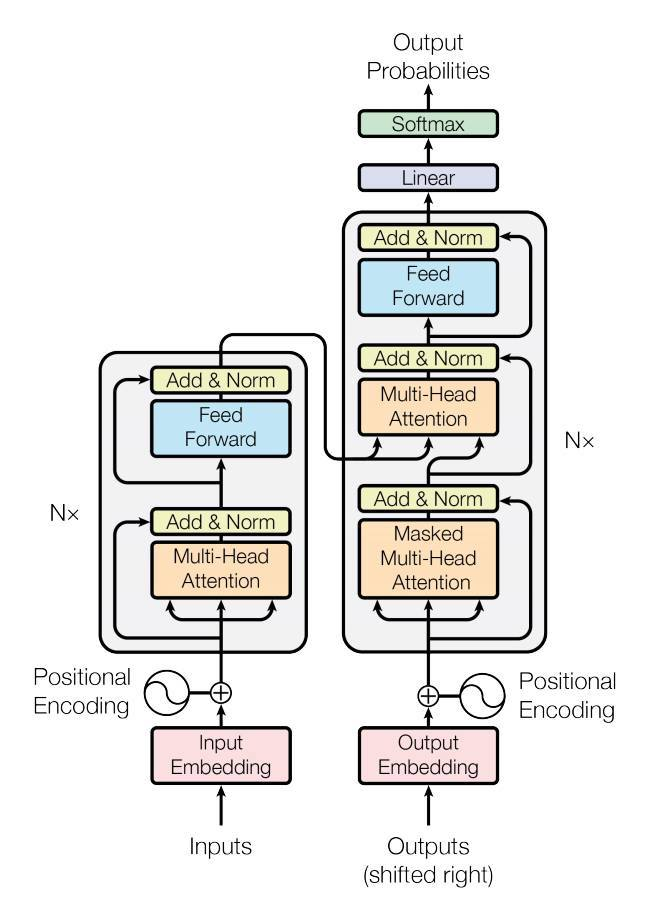

- full decoder layer of the Transformer
- contains 2 Multi-Head Self Attention layers with residual connections and layer normalization, 

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):

  def __init__(self, d_model, dff, num_heads, rate=0.1):
    super(DecoderLayer, self).__init__()
    self.attn1 = MultiHeadAttention(d_model, num_heads)
    self.attn2 = MultiHeadAttention(d_model, num_heads)
    self.ffn = PointWiseFeedForward(d_model, dff)
    self.layernorm1 = LayerNormalization()
    self.layernorm2 = LayerNormalization()
    self.layernorm3 = LayerNormalization()

    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)
    self.dropout3 = Dropout(rate)
  
  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

    attn1, attn_weights_block1 = self.attn1(x, x, x, look_ahead_mask) 
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.attn2(
        enc_output, enc_output, out1, padding_mask) 
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1) 

    ffn_output = self.ffn(out2) 
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2) 

    

    return out3, attn_weights_block1, attn_weights_block2




In [ ]:
class WeightedDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, d_model, dff, n_branches, rate=0.1):
        super(WeightedDecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(d_model, n_branches)
        self.dec_enc_attn = BranchedMultiHeadAttention(d_model, dff, n_branches, rate)

        self.dropout = Dropout(rate)
        self.layernorm = LayerNormalization()

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(x, x, x, look_ahead_mask)
        dec_outputs = self.dropout(dec_outputs, training=training)
        dec_outputs = self.layernorm(x + dec_outputs)

        dec_outputs, dec_enc_attn = self.dec_enc_attn(enc_output, enc_output, dec_outputs, padding_mask, training)
        
        return dec_outputs, dec_self_attn, dec_enc_attn

In [ ]:
class Decoder(tf.keras.layers.Layer):

  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = pos_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model=d_model,dff=dff, num_heads=num_heads, rate=rate)
                       for _ in range(num_layers)]

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x) 
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    return x, attention_weights


In [ ]:
class WeightedDecoder(tf.keras.layers.Layer):

  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(WeightedDecoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = pos_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [WeightedDecoderLayer(d_model=d_model, dff=dff, n_branches=num_heads, rate=rate)
                       for _ in range(num_layers)]

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x) 
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    return x, attention_weights


In [ ]:
class Transformer(tf.keras.Model):

  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.tokenizer = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                             input_vocab_size=input_vocab_size, maximum_position_encoding=pe_input,rate=rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, maximum_position_encoding=pe_target,rate=rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_all_masks(inp, tar)

    enc_output = self.tokenizer(inp, training, enc_padding_mask) 

    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output) 

    return final_output, attention_weights
  
  def create_all_masks(self, inp, tar):
    enc_padding_mask = create_padding_mask(inp)
  
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_tar_padding_mask = create_padding_mask(tar)
    combined = tf.maximum(dec_tar_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined, dec_padding_mask

In [ ]:
class WeightedTransformer(tf.keras.Model):

  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(WeightedTransformer, self).__init__()

    self.tokenizer = WeightedEncoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                             input_vocab_size=input_vocab_size, maximum_position_encoding=pe_input,rate=rate)

    self.decoder = WeightedDecoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, maximum_position_encoding=pe_target,rate=rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_all_masks(inp, tar)

    enc_output = self.tokenizer(inp, training, enc_padding_mask) 

    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output) 

    return final_output, attention_weights
  
  def create_all_masks(self, inp, tar):
    enc_padding_mask = create_padding_mask(inp)
  
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_tar_padding_mask = create_padding_mask(tar)
    combined = tf.maximum(dec_tar_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined, dec_padding_mask

In [ ]:
class TransformerLearningRate(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps = 4000):
    super(TransformerLearningRate, self).__init__()
    self.d_model = tf.cast(d_model, tf.float32)
    self.warmup_steps = warmup_steps
  
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


# Training and evaluating

- function to create all masks needed for the Transformer at once

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction = 'none')
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

from tensorflow.keras.losses import categorical_crossentropy

def scce_with_ls(y, y_hat):
    y = tf.one_hot(tf.cast(y, tf.int32), n_classes)
    return categorical_crossentropy(y, y_hat, label_smoothing = 0.1)
  
def loss_func(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real,0))
  loss_ = loss(real,pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/ tf.reduce_sum(mask)

def acc_func(real,pred):
  mask = tf.math.logical_not(tf.math.equal(real,0))
  accuracy = tf.equal(real, tf.argmax(pred, axis=2))
  accuracy = tf.math.logical_and(mask, accuracy)

  accuracy = tf.cast(accuracy, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracy)/tf.reduce_sum(mask)


- **Test out the difference between using the regular Transformer and the Weighted Transformer**

In [ ]:
learning_rate = TransformerLearningRate(d_model=d_model, warmup_steps = 4000)
optimizer = Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
transformer = WeightedTransformer(d_model=d_model,
                          dff=dff,
                          num_heads=num_heads, 
                          num_layers=num_layers, 
                          input_vocab_size=enc_vocab_size,
                          target_vocab_size=dec_vocab_size,
                          pe_input=max_pos_enc,
                          pe_target=max_pos_dec,
                          rate=dropout_rate)




train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 True)

    loss = loss_func(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(acc_func(tar_real, predictions))

def test_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  predictions, _ = transformer([inp, tar_inp],
                                 False)

  loss = loss_func(tar_real, predictions)


  val_loss(loss)
  val_accuracy(acc_func(tar_real, predictions))


In [ ]:
for i in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  val_loss.reset_states()
  val_accuracy.reset_states()

  for (batch,(x,y)) in enumerate(training_dataset):
    train_step(x,y)
    if batch % 100 == 0:
      print(f'Epoch {i+1}, Batch {batch}: loss: {train_loss.result()}, accuracy: {train_accuracy.result()}')

  
  for (batch, (x,y)) in enumerate(val_dataset):
    test_step(x,y)
    
    
  print(f'Epoch {i+1}, train loss:{train_loss.result()}, accuracy: {train_accuracy.result()}, val loss:{val_loss.result()}, val accuracy:{val_accuracy.result()}, time: {(time.time() - start)/60}')



*   Save model to be used later


In [ ]:
transformer.save("/content/drive/MyDrive/ch_to_en_transformer")

In [ ]:
transformer = keras.models.load_model("/content/drive/MyDrive/ch_to_en_transformer")



*   Confirming that the trained model was actually loaded back



In [ ]:
start = time.time()

#acting as test loss and test accuracy here
val_loss.reset_states()
val_accuracy.reset_states()

for (batch, (x,y)) in enumerate(test_dataset):
  test_step(x,y)
    
print(f'test loss:{val_loss.result()}, test accuracy:{val_accuracy.result()}, time: {(time.time() - start)/60}')



*   **Use this class to run inference**



In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizer_inp, tokenizer_out, model):
    self.tokenizer_inp = tokenizer_inp
    self.tokenizer_out = tokenizer_out
    self.transformer = model

  def __call__(self, sentence, max_length=50):

    enc_inp = tf.cast(tf.keras.preprocessing.sequence.pad_sequences(self.tokenizer_in.texts_to_sequences([ch_preprocess_sentence(sentence)]), maxlen=max_length, padding='post'), dtype=tf.int64)

    start, end = self.tokenizer_inp.texts_to_sequences([en_preprocess_sentence('')])[0]

    attention_weights = 0
 

    output_array = [start]

    for i in range(max_length):
      output = tf.cast(tf.keras.preprocessing.sequence.pad_sequences(tf.expand_dims(output_array, 0), maxlen = max_length, padding='post'), dtype=tf.int64)
      predictions, attention_weights = self.transformer([enc_inp, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      
      output_array.append(tf.squeeze(predicted_id).numpy())
      

      if predicted_id == end or predicted_id == start:
        break

    # output.shape (1, tokens)
    text = self.tokenizer_out.sequences_to_texts([output_array]) # shape: ()

    return text, output_array, attention_weights



    

